In [1]:
# Import netket library
import netket as nk
# Import Json, this will be needed to examine log files
import json
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
# Define a 1d chain
L = 22
g = nk.graph.Hypercube(length=L, n_dim=1, pbc=True)

In [3]:
# Define the Hilbert space based on this graph
# We impose to have a fixed total magnetization of zero
hi = nk.hilbert.Spin(s=0.5, graph=g, total_sz=0)

In [4]:
# calling the Heisenberg Hamiltonian
ha = nk.operator.Heisenberg(hilbert=hi)

In [5]:
# compute the ground-state energy (here we only need the lowest energy, and do not need the eigenstate)
exact_result = nk.exact.lanczos_ed(ha, first_n=1, compute_eigenvectors=False)
exact_gs_energy = exact_result.eigenvalues[0]
print('The exact ground-state energy is E0=',exact_gs_energy)

# Just in case you can't do this calculation, here is the result
# exact_gs_energy = -39.14752260706246

The exact ground-state energy is E0= -39.14752260706246


In [6]:
ma = nk.machine.Jastrow(hilbert=hi)
ma.init_random_parameters(seed=1, sigma=0.01)

In [7]:
# Optimizer
op = nk.optimizer.Sgd(learning_rate=0.1)

# Sampler
sa = nk.sampler.MetropolisExchange(machine=ma,graph=g)
ma.init_random_parameters(seed=12, sigma=0.01)

# Stochastic reconfiguration
gs = nk.variational.Vmc(
    hamiltonian=ha,
    sampler=sa,
    optimizer=op,
    n_samples=1000,
    diag_shift=0.1,
    method='Sr')

start = time.time()
gs.run(output_prefix='Jastrow', n_iter=300)
end = time.time()

print('### Jastrow calculation')
print('Has',ma.n_par,'parameters')
print('The Jastrow calculation took',end-start,'seconds')

### Jastrow calculation
Has 231 parameters
The Jastrow calculation took 19.8570613861084 seconds


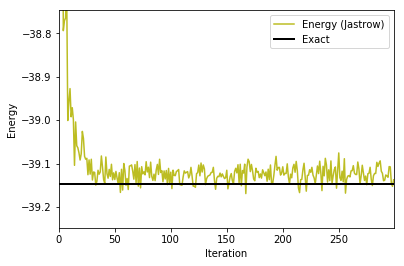

In [8]:
# import the data from log file
data=json.load(open("Jastrow.log"))

# Extract the relevant information
iters_Jastrow=[]
energy_Jastrow=[]

for iteration in data["Output"]:
    iters_Jastrow.append(iteration["Iteration"])
    energy_Jastrow.append(iteration["Energy"]["Mean"])

fig, ax1 = plt.subplots()
ax1.plot(iters_Jastrow, energy_Jastrow, color='C8', label='Energy (Jastrow)')
ax1.set_ylabel('Energy')
ax1.set_xlabel('Iteration')
plt.axis([0,iters_Jastrow[-1],exact_gs_energy-0.1,exact_gs_energy+0.4])
plt.axhline(y=exact_gs_energy, xmin=0,
                xmax=iters_Jastrow[-1], linewidth=2, color='k', label='Exact')
ax1.legend()
plt.show()

In [9]:
# RBM ansatz with alpha=1
ma = nk.machine.RbmSpin(alpha=1, hilbert=hi)

In [10]:
# Sampler
sa = nk.sampler.MetropolisExchange(machine=ma,graph=g)
ma.init_random_parameters(seed=123, sigma=0.01)

# Optimizer
op = nk.optimizer.Sgd(learning_rate=0.05)
# Stochastic reconfiguration
gs = nk.variational.Vmc(
    hamiltonian=ha,
    sampler=sa,
    optimizer=op,
    n_samples=1000,
    diag_shift=0.1,
    use_iterative=True,
    method='Sr')

start = time.time()
gs.run(output_prefix='RBM', n_iter=600)
end = time.time()

print('### RBM calculation')
print('Has',ma.n_par,'parameters')
print('The RBM calculation took',end-start,'seconds')

### RBM calculation
Has 528 parameters
The RBM calculation took 216.61890292167664 seconds


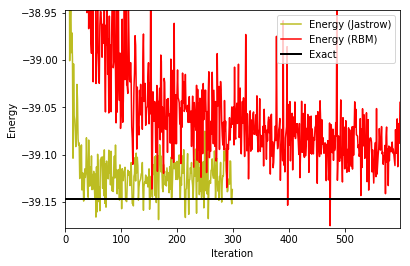

In [11]:
# import the data from log file
data=json.load(open("RBM.log"))

# Extract the relevant information
iters=[]
energy_RBM=[]

for iteration in data["Output"]:
    iters.append(iteration["Iteration"])
    energy_RBM.append(iteration["Energy"]["Mean"])

fig, ax1 = plt.subplots()
ax1.plot(iters_Jastrow, energy_Jastrow, color='C8', label='Energy (Jastrow)')
ax1.plot(iters, energy_RBM, color='red', label='Energy (RBM)')
ax1.set_ylabel('Energy')
ax1.set_xlabel('Iteration')
plt.axis([0,iters[-1],exact_gs_energy-0.03,exact_gs_energy+0.2])
plt.axhline(y=exact_gs_energy, xmin=0,
                xmax=iters[-1], linewidth=2, color='k', label='Exact')
ax1.legend()
plt.show()

In [12]:
# Symmetric RBM Spin Machine
ma = nk.machine.RbmSpinSymm(alpha=1, hilbert=hi)
ma.init_random_parameters(seed=1234, sigma=0.01)

# Metropolis Exchange Sampling
# Notice that this sampler exchanges two neighboring sites
# thus preservers the total magnetization
sa = nk.sampler.MetropolisExchange(machine=ma, graph=g)

# Optimizer
op = nk.optimizer.Sgd(learning_rate=0.05)

# Stochastic reconfiguration
gs = nk.variational.Vmc(
    hamiltonian=ha,
    sampler=sa,
    optimizer=op,
    n_samples=1000,
    diag_shift=0.1,
    use_iterative=True,
    method='Sr')

start = time.time()
gs.run(output_prefix='RBMSymmetric', n_iter=300)
end = time.time()

print('### Symmetric RBM calculation')
print('Has',ma.n_par,'parameters')
print('The Symmetric RBM calculation took',end-start,'seconds')

### Symmetric RBM calculation
Has 24 parameters
The Symmetric RBM calculation took 99.26796174049377 seconds


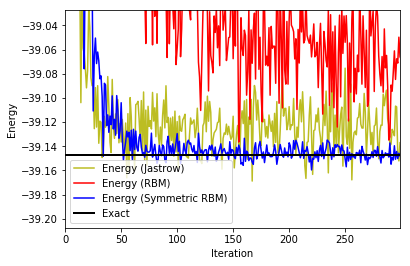

In [13]:
# import the data from log file
data=json.load(open("RBMSymmetric.log"))

# Extract the relevant information
energy_symRBM=[]
iters_symRBM=[]
for iteration in data["Output"]:
    energy_symRBM.append(iteration["Energy"]["Mean"])
    iters_symRBM.append(iteration["Iteration"])

fig, ax1 = plt.subplots()
ax1.plot(iters_Jastrow, energy_Jastrow, color='C8', label='Energy (Jastrow)')
ax1.plot(iters, energy_RBM, color='red', label='Energy (RBM)')
ax1.plot(iters_symRBM, energy_symRBM, color='blue', label='Energy (Symmetric RBM)')

ax1.set_ylabel('Energy')
ax1.set_xlabel('Iteration')
plt.axis([0,iters_symRBM[-1],exact_gs_energy-0.06,exact_gs_energy+0.12])
plt.axhline(y=exact_gs_energy, xmin=0,
                xmax=iters[-1], linewidth=2, color='k', label='Exact')
ax1.legend()
plt.show()

In [14]:
layers = (nk.layer.FullyConnected(input_size=L,output_size=int(2*L),use_bias=True),
          nk.layer.Lncosh(input_size=int(2*L)),
          nk.layer.SumOutput(input_size=int(2*L))
         )
for layer in layers:
    layer.init_random_parameters(seed=12345, sigma=0.01)

ffnn = nk.machine.FFNN(hi, layers)

sa = nk.sampler.MetropolisExchange(graph=g, machine=ffnn)

opt = nk.optimizer.Sgd(learning_rate=0.05)

gs = nk.variational.Vmc(hamiltonian=ha,
                        sampler=sa,
                        optimizer=opt,
                        n_samples=1000,
                        use_iterative=True,
                        method='Sr')

start = time.time()
gs.run(output_prefix='FF', n_iter=300)
end = time.time()

print('### Feed Forward calculation')
print('Has',ffnn.n_par,'parameters')
print('The Feed Forward calculation took',end-start,'seconds')

### Feed Forward calculation
Has 1012 parameters
The Feed Forward calculation took 202.93756914138794 seconds
